# Обучение моделей прогнозирования показателей результативности обучения на курсах

### Задача
Построить модели машинного обучения, предсказывающие результативность завершения учебных курсов пользователями образовательной платформы. Сериализовать модели для дальнейшей интеграции в веб-приложение.

### Исходные данные:
1. 20241125_all_course.csv - сводный датасет по итогам подготовки на "детских" 3, 49, 71 и 77 курсах.
2. 20241128_new_data.csv - сводный датасет по итогам подготовки на курсах 1Т Дата - 76, 77, 82 и 83 курсы.

## Ход решения задачи

## 1. Загрузка и предобработка данных

In [1]:
# Импорт библиотек для работы с данными
import pandas as pd
import numpy as np

# Импорт метрики MAE
from sklearn.metrics import mean_absolute_error

# Импорт инструментов визуализации
import matplotlib.pyplot as plt
import seaborn as sns
# from phik.report import plot_correlation_matrix

#### 1.1 Загрузка данных

#### Описание датасета 20241125_all_course

Датасет представляет собой выборку по итогам прохождения "детских" курсов и предназначен для обучения модели искусственного интеллекта в рамках разработки системы скоринга обучающихся, позволяющей прогнозировать уровень вовлеченности и вероятность успешного завершения курса каждым учеником. Кроме того, датасет подходит для предсказания статуса ("активный", "засыпающий", "спящий").
Датасет содержит 55 столбцов и 4991 строк.
Датасет содержит информацию о 4990 уникальных пользователях. Для каждого пользователя подсчитаны показатели и данные на 10 недель, начиная с 2023-12-01 (начало обучения на курсе) с интервалом в 1 неделю. В датасете содержится изменение значений метрик в течение всего периода обучения.

**Информация по столбцам:**
* user_id - уникальный идентификатор пользователя
* course_id	- идентификатор курса обучения

**Признаки для обучения модели имеют структуру данных, агрегированных за 10 недель обучения, в формате 'feature_{i}_week', где в каждом столбце - показатели за конкретную неделю обучения:**
* required_activities_delay_1_week, ... , required_activities_delay_10_week - задержка в днях в выполнении заданий, накопленная за 1 - 10 недели
* success_required_done_1_week, ... , success_required_done_10_week - количество сделанных обязательных заданий за 1 - 10 недели
* mean_result_required_1_week, ... , mean_result_required_10_week - средняя оценка за выполненные обязательные задания за 1 - 10 недели
* cur_date_progress_1_week, ... , cur_date_progress_1_week - прогресс в выполнении обязательных заданий за 1 - 10 недели
* current_progress_1_week, ... , current_progress_10_week - накопленный общий прогресс по всему курсу обучения за 1 - 10 недели

**Целевые признаки:**
* end_status - ("активный", "засыпающий", "спящий") на конец обучения
* m2_progress - фактический накопленный общий прогресс по курсу
* m2_success - успешность окончания курса (0 – не окончил, 1 – окончил успешно).

In [2]:
# Загружаем датасет с "детскими" курсами
df_old = pd.read_csv('./original_dataset/20241125_all_course.csv')
df_old.head(5)

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,end_status,m2_progress,m2_success
0,2614,77,4,1,4,4,0,1,0,1,...,38,50,55,77,88,100,100,2,100,1
1,6766,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
2,7722,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
3,10159,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
4,14558,71,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0


Структура датасета по итогам прохождения курсов 1Т Дата  совпадает с "детскими" курсами. Но при этом имеются различия в названии столбцов:
* столбец 'm2_progress' переименован на 'real_course_progress'
* столбец 'm2_success' переименован на 'course_success'.

In [3]:
# Загружаем датасет с курсами 1Т Дата
df_new = pd.read_csv('./original_dataset/20241128_new_data.csv')

# Переименовываем столбцы датафрейма df_new
df_new.rename(columns={
    'real_course_progress': 'm2_progress',
    'course_success': 'm2_success'
}, inplace=True)

# Заменяем значения в столбце course_id
df_new['course_id'] = df_new['course_id'].replace(77, 770)
df_new.head(5)

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,end_status,m2_progress,m2_success
0,71,82,2,19,59,125,210,320,458,624,...,5,5,5,5,5,5,5,0,13,0
1,171,82,2,11,28,42,51,57,75,111,...,21,28,40,54,59,71,78,2,88,1
2,192,82,2,11,20,33,38,67,91,125,...,22,30,32,40,47,62,70,2,92,1
3,1165,82,2,11,33,67,81,105,191,308,...,15,22,30,30,30,35,45,1,57,1
4,1315,770,0,7,37,65,125,206,308,431,...,8,8,8,8,8,8,8,0,100,0


* В обоих датасетах имеется признак 'end_status', который не будет применяться в данной работе. Поэтому мы его удаляем.

In [4]:
# Объединяем два датафрейма в один
df = pd.concat([df_old, df_new], axis = 0, ignore_index=True)
# Удаляем столбец 'end_status'
df.drop(['end_status'], axis=1, inplace=True)
df.sample(5)

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_3_week,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,m2_progress,m2_success
1420,65074,3,4,4,4,0,0,1,0,4,...,33,55,55,61,77,77,100,100,94,1
1383,64820,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
773,48371,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0
837,51035,49,11,25,46,28,42,56,62,70,...,17,47,47,47,64,82,88,88,94,0
4806,199900199,3,4,22,54,100,156,216,290,378,...,0,0,0,0,0,0,0,0,0,0


В объединенном датасете наблюдается значительный дисбаланс обучающихся из разных курсов. Чтобы минимизировать негативное влияние этого дисбаланса на обучение моделей, создадим обучающую стратифицированную выборку.

In [5]:
# Создаем обучающую стратифицированную выборку

# Шаг 1: Выбор записей из различных курсов с заданным количеством
# Определяем количество записей для каждого курса
sample_sizes = {
    77: 350,
    3: 1000,
    71: 1000,
    49: 1500,
    82: 180,
    770: 100,
    76: 50,
    83: 150
}

# Создаем пустой список для хранения выборок
samples = []

# Выбираем записи для каждого курса
for course_id, size in sample_sizes.items():
    # Выборка с заменой для курсов, где размер меньше необходимого
    course_sample = df[df['course_id'] == course_id].sample(n=size, replace=True)
    
    # Масштабируем до 1500 записей
    if len(course_sample) < 1500:
        course_expanded = course_sample.sample(n=1500, replace=True)
    else:
        course_expanded = course_sample.sample(n=1500)
    
    samples.append(course_expanded)

# Объединение всех выборок в одну обучающую выборку
train_sample = pd.concat(samples)

# Проверка результата
print("\nРазмер итоговой выборки:", len(train_sample))
for course_id in sample_sizes.keys():
    print(f"\nКоличество записей из course_id={course_id}:", len(train_sample[train_sample['course_id'] == course_id]))


Размер итоговой выборки: 12000

Количество записей из course_id=77: 1500

Количество записей из course_id=3: 1500

Количество записей из course_id=71: 1500

Количество записей из course_id=49: 1500

Количество записей из course_id=82: 1500

Количество записей из course_id=770: 1500

Количество записей из course_id=76: 1500

Количество записей из course_id=83: 1500


In [6]:
# Создаем валидационную выборку методом исключения из датасета обучающих примеров
val_sample = df.drop(train_sample.index)

# Проверка результатов
print("Размер обучающей стратифицированной выборки:")
print(len(train_sample))
print("\nРазмер валидационной выборки:")
print(len(val_sample))

Размер обучающей стратифицированной выборки:
12000

Размер валидационной выборки:
2808


#### 1.2. Предварительный анализ данных

In [7]:
# Проверяем на пропуски
val_sample.isna().sum()

user_id                              0
course_id                            0
required_activities_delay_1_week     0
required_activities_delay_2_week     0
required_activities_delay_3_week     0
required_activities_delay_4_week     0
required_activities_delay_5_week     0
required_activities_delay_6_week     0
required_activities_delay_7_week     0
required_activities_delay_8_week     0
required_activities_delay_9_week     0
required_activities_delay_10_week    0
success_required_done_1_week         0
success_required_done_2_week         0
success_required_done_3_week         0
success_required_done_4_week         0
success_required_done_5_week         0
success_required_done_6_week         0
success_required_done_7_week         0
success_required_done_8_week         0
success_required_done_9_week         0
success_required_done_10_week        0
mean_result_required_1_week          0
mean_result_required_2_week          0
mean_result_required_3_week          0
mean_result_required_4_we

**Выводы:**
* в датасете нет пропусков, он хорошо подходит для обучения моделей;
* целесообразно обучить модели, прогнозирующие как успешность завершения курса 'm2_success', так и прогресс, которого достигнет обучающийся 'm2_progress'.

#### 1.3. Создание отдельных датасетов для каждой недели

* Формируем обучающие и валидационные выборки на каждую неделю. Особенности: датасет за 10 неделю содержат все данные исходной выборки, в датасете за 9 неделю заполняем нулями данные за 10 неделю, в датасете за 8 неделю - данные за 9 и 10 недели и т.д.

*Это позволяет с одной стороны сохранить структуру датасета, с другой - избежать "подглядывания" моделей в будущее*.

In [8]:
# Функция формирования еженедельных датасетов
def create_weekly_dataframes_with_zeros_and_globals(base_df, total_weeks=10, prefix='train'):
    """
    Args:
        base_df (pd.DataFrame): Исходный датафрейм.
        total_weeks (int): Общее количество недель.
        prefix (str): Префикс для именования глобальных переменных (например, 'train' или 'val').
    Returns:
        None: Датафреймы сохраняются как глобальные переменные.
    """
    global_vars = globals()  # Доступ к глобальным переменным

    for current_week in range(1, total_weeks + 1):
        # Копируем исходный датафрейм
        weekly_df = base_df.copy()

        # Обнуляем данные будущих недель
        for future_week in range(current_week + 1, total_weeks + 1):
            for col in weekly_df.columns:
                if f'_{future_week}_week' in col:
                    weekly_df[col] = 0

        # Сохраняем датафрейм как глобальную переменную
        global_vars[f'{prefix}_week_{current_week}'] = weekly_df

# Применение функции для тренировочных и валидационных данных
create_weekly_dataframes_with_zeros_and_globals(train_sample, total_weeks=10, prefix='train')
create_weekly_dataframes_with_zeros_and_globals(val_sample, total_weeks=10, prefix='val')

* Сохраняем полученные датасеты в отдельные файлы csv (при необходимости)

In [9]:
# import os

# # Папка для сохранения файлов (убедитесь, что директория существует)
# save_directory = './saved_datasets/'

# # Создаем директорию, если она не существует
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)

# # Список для тренировочных и валидационных датасетов
# train_datasets = [train_week_1, train_week_2, train_week_3, train_week_4, 
#                   train_week_5, train_week_6, train_week_7, train_week_8, 
#                   train_week_9, train_week_10]

# val_datasets = [val_week_1, val_week_2, val_week_3, val_week_4, 
#                 val_week_5, val_week_6, val_week_7, val_week_8, 
#                 val_week_9, val_week_10]

# # Сохранение обучающих данных
# for i in range(10):
#     file_name_train = f'{save_directory}train_week_{i + 1}.csv'
#     train_datasets[i].to_csv(file_name_train, index=False)  # Сохраняем DataFrame в CSV

# # Сохранение валидационных данных
# for i in range(10):
#     file_name_val = f'{save_directory}val_week_{i + 1}.csv'
#     val_datasets[i].to_csv(file_name_val, index=False)  # Сохраняем DataFrame в CSV

# print("Файлы сохранены.")

## 2. Обучение моделей прогнозирования прогресса по курсу

#### 2.1. Обучение простых моделей

2.1.1. Линейная регрессия

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

# Функция обучения модели линейной регрессии с использованием Pipeline
def create_linear_regression(X, y):
    # Создание конвейера с импутером и моделью линейной регрессии
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средними значениями
        ('model', LinearRegression())  # Модель линейной регрессии
    ])
    
    # Обучение модели
    pipeline.fit(X, y)

    return pipeline  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
lr_models = {}  # Словарь для моделей
lr_maes = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
lr_predictions_df = pd.DataFrame()

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = train_week['m2_progress']
    
    # Обучение модели линейной регрессии с обработкой пропусков
    lr_model = create_linear_regression(X_week, y_week)

    # Сохранение модели в словарь
    lr_models[f'lr_model_week_{week}'] = lr_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_val_week = val_week['m2_progress']

    predictions = lr_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    lr_maes.append(mae)

    # Добавление предсказаний в DataFrame
    lr_predictions_df[f'predictions_val_week_{week}'] = predictions

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {lr_maes[week]}")

Validation Week 1 - Mean Absolute Error: 16.7848445857647
Validation Week 2 - Mean Absolute Error: 10.001622838234654
Validation Week 3 - Mean Absolute Error: 8.181107215305166
Validation Week 4 - Mean Absolute Error: 7.325009743299779
Validation Week 5 - Mean Absolute Error: 6.434888439980514
Validation Week 6 - Mean Absolute Error: 6.665979110341657
Validation Week 7 - Mean Absolute Error: 6.139922397678053
Validation Week 8 - Mean Absolute Error: 4.784093801846963
Validation Week 9 - Mean Absolute Error: 3.631262318401354
Validation Week 10 - Mean Absolute Error: 2.9372265138280107


2.1.2. Дерево решений

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pandas as pd
import os

# Создание папки для сохранения графиков, если она не существует
# output_dir = '/home/shared_notebooks/zloy/trees'
# os.makedirs(output_dir, exist_ok=True)

# Функция обучения модели решающего дерева
def create_decision_tree(X, y):
    # Создание и настройка модели решающего дерева
    dt_model = DecisionTreeRegressor(random_state=42)
    
    # Обучение модели
    dt_model.fit(X, y)

    return dt_model  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
dt_models = {}  # Словарь для моделей
dt_maes = []    # Список для MAE

# Создание списка для хранения предсказаний
dt_predictions = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_progress']  # Целевая переменная
    
    # Обучение модели решающего дерева
    dt_model = create_decision_tree(X_week, y_week)

    # Сохранение модели в словарь
    dt_models[f'dt_model_week_{week}'] = dt_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_progress']  # Целевая переменная

    predictions = dt_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    dt_maes.append(mae)

    # Добавление предсказаний в список
    dt_predictions.append(predictions)

    # Визуализация решающего дерева с использованием plot_tree (при необходимости)
#     plt.figure(figsize=(20, 10))
#     plot_tree(dt_model, 
#               feature_names=X_week.columns,
#               filled=True,
#               rounded=True)
    
#     plt.title(f"Decision Tree - Week {week}")
    
    # plt.savefig(os.path.join(output_dir, f"decision_tree_week_{week}.png"))  # Сохранение графика в формате PNG
    # plt.close()  # Закрытие фигуры для освобождения памяти

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {dt_maes[week]}")

Validation Week 1 - Mean Absolute Error: 10.781712115045448
Validation Week 2 - Mean Absolute Error: 7.340354090354091
Validation Week 3 - Mean Absolute Error: 6.367775742775743
Validation Week 4 - Mean Absolute Error: 5.837861212861213
Validation Week 5 - Mean Absolute Error: 5.337505087505088
Validation Week 6 - Mean Absolute Error: 4.957875457875458
Validation Week 7 - Mean Absolute Error: 4.511294261294261
Validation Week 8 - Mean Absolute Error: 3.658017908017908
Validation Week 9 - Mean Absolute Error: 3.017704517704518
Validation Week 10 - Mean Absolute Error: 2.234940984940985


#### 2.2 Обучение ансамблей моделей

2.2.1. Случайный лес

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Функция обучения модели случайного леса
def create_random_forest(X, y):
    # Создание и настройка модели случайного леса
    rf_model = RandomForestRegressor()

    # Обучение модели
    rf_model.fit(X, y)

    return rf_model  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
rf_models = {}  # Словарь для моделей
rf_maes = []    # Список для MAE

# Создание списка для хранения предсказаний
rf_predictions = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_progress']  # Целевая переменная
    
    # Обучение модели случайного леса
    rf_model = create_random_forest(X_week, y_week)

    # Сохранение модели в словарь
    rf_models[f'rf_model_week_{week}'] = rf_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_progress']  # Целевая переменная

    predictions = rf_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    rf_maes.append(mae)

    # Добавление предсказаний в список
    rf_predictions.append(predictions)

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {rf_maes[week]}")

Validation Week 1 - Mean Absolute Error: 10.210441774472757
Validation Week 2 - Mean Absolute Error: 6.409239463942989
Validation Week 3 - Mean Absolute Error: 5.665018575441652
Validation Week 4 - Mean Absolute Error: 4.947019766380343
Validation Week 5 - Mean Absolute Error: 4.3772878658022885
Validation Week 6 - Mean Absolute Error: 4.152612605284079
Validation Week 7 - Mean Absolute Error: 3.692600511964294
Validation Week 8 - Mean Absolute Error: 2.9967263282183154
Validation Week 9 - Mean Absolute Error: 2.452401147700827
Validation Week 10 - Mean Absolute Error: 2.0235947281588307


2.2.2. Градиентный бустинг sklearn

In [13]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

# Функция обучения модели градиентного бустинга с использованием Pipeline
def create_gradient_boosting(X, y):
    # Создание конвейера с импутером и моделью градиентного бустинга
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средними значениями
        ('model', GradientBoostingRegressor())  # Модель градиентного бустинга
    ])
    
    # Обучение модели
    pipeline.fit(X, y)

    return pipeline  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
gb_models = {}  # Словарь для моделей
gb_maes = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
gb_predictions_df = pd.DataFrame()

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = train_week['m2_progress']
    
    # Обучение модели градиентного бустинга с обработкой пропусков
    gb_model = create_gradient_boosting(X_week, y_week)

    # Сохранение модели в словарь
    gb_models[f'gb_model_week_{week}'] = gb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_val_week = val_week['m2_progress']

    predictions = gb_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    gb_maes.append(mae)

    # Добавление предсказаний в DataFrame
    gb_predictions_df[f'predictions_val_week_{week}'] = predictions

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {gb_maes[week]}")

Validation Week 1 - Mean Absolute Error: 10.199957302004366
Validation Week 2 - Mean Absolute Error: 6.744021131591847
Validation Week 3 - Mean Absolute Error: 5.857870372665475
Validation Week 4 - Mean Absolute Error: 5.233179595295066
Validation Week 5 - Mean Absolute Error: 4.602352865851993
Validation Week 6 - Mean Absolute Error: 4.461068881316655
Validation Week 7 - Mean Absolute Error: 4.052769903245758
Validation Week 8 - Mean Absolute Error: 3.1730288684889443
Validation Week 9 - Mean Absolute Error: 2.590442765606956
Validation Week 10 - Mean Absolute Error: 2.0898386035379226


2.2.3. XGBoost

In [14]:
from xgboost import XGBRegressor

# Функция обучения модели XGBoost
def create_xgboost(X, y):
    # Создание и настройка модели XGBoost
    xgb_model = XGBRegressor()

    # Обучение модели
    xgb_model.fit(X, y)

    return xgb_model  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
xgb_models = {}  # Словарь для моделей
xgb_maes = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
xgb_predictions_df = pd.DataFrame()

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = train_week['m2_progress']
    
    # Обучение модели XGBoost
    xgb_model = create_xgboost(X_week, y_week)

    # Сохранение модели в словарь
    xgb_models[f'xgb_model_week_{week}'] = xgb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)
    y_val_week = val_week['m2_progress']

    predictions = xgb_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    xgb_maes.append(mae)

    # Добавление предсказаний в DataFrame
    xgb_predictions_df[f'predictions_val_week_{week}'] = predictions

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {xgb_maes[week]}")

Validation Week 1 - Mean Absolute Error: 10.042438260748241
Validation Week 2 - Mean Absolute Error: 6.5418357230738495
Validation Week 3 - Mean Absolute Error: 5.764912078278872
Validation Week 4 - Mean Absolute Error: 4.905310758348882
Validation Week 5 - Mean Absolute Error: 4.3583442720890035
Validation Week 6 - Mean Absolute Error: 4.243670497220799
Validation Week 7 - Mean Absolute Error: 3.8126595074795464
Validation Week 8 - Mean Absolute Error: 3.076161318006554
Validation Week 9 - Mean Absolute Error: 2.502345082939573
Validation Week 10 - Mean Absolute Error: 2.0501856072988653


2.2.4. CatBoost

In [15]:
from catboost import CatBoostRegressor

# Функция обучения модели CatBoost
def create_catboost(X, y):
    # Создание и настройка модели CatBoost
    catboost_model = CatBoostRegressor(silent=True)  # Устанавливаем silent=True, чтобы отключить вывод

    # Обучение модели
    catboost_model.fit(X, y)

    return catboost_model  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
catboost_models = {}  # Словарь для моделей
catboost_maes = []    # Список для MAE

# Создание списка для хранения предсказаний
catboost_predictions = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_progress']  # Целевая переменная
    
    # Обучение модели CatBoost
    catboost_model = create_catboost(X_week, y_week)

    # Сохранение модели в словарь
    catboost_models[f'catboost_model_week_{week}'] = catboost_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_progress']  # Целевая переменная

    predictions = catboost_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    catboost_maes.append(mae)

    # Добавление предсказаний в список
    catboost_predictions.append(predictions)

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {catboost_maes[week]}")

Validation Week 1 - Mean Absolute Error: 9.847911510515189
Validation Week 2 - Mean Absolute Error: 6.202090052434234
Validation Week 3 - Mean Absolute Error: 5.557845328605116
Validation Week 4 - Mean Absolute Error: 4.666563205404899
Validation Week 5 - Mean Absolute Error: 4.176189809085815
Validation Week 6 - Mean Absolute Error: 4.13209718194636
Validation Week 7 - Mean Absolute Error: 3.5907583556737697
Validation Week 8 - Mean Absolute Error: 2.9780328510317085
Validation Week 9 - Mean Absolute Error: 2.3548886258048296
Validation Week 10 - Mean Absolute Error: 1.9343704342680406


2.2.5. Light Gradient Boosted Machine

In [16]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# Функция обучения модели LightGBM
def create_lightgbm(X, y):
    # Создание и настройка модели LightGBM
    lgb_model = lgb.LGBMRegressor()

    # Обучение модели
    lgb_model.fit(X, y)

    return lgb_model  # Возвращаем модель

# Словарь для хранения моделей и список для MAE
lgb_models = {}  # Словарь для моделей
lgb_maes = []    # Список для MAE

# Создание списка для хранения предсказаний
lgb_predictions = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_progress']  # Целевая переменная
    
    # Обучение модели LightGBM
    lgb_model = create_lightgbm(X_week, y_week)

    # Сохранение модели в словарь
    lgb_models[f'lgb_model_week_{week}'] = lgb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_progress']  # Целевая переменная

    predictions = lgb_model.predict(X_val_week)

    # Оценка модели на валидационных данных
    mae = mean_absolute_error(y_val_week, predictions)
    
    # Добавление MAE в список
    lgb_maes.append(mae)

    # Добавление предсказаний в список (если нужно)
    lgb_predictions.append(predictions)

# Вывод MAE для каждой недели на валидационных данных
for week in range(10):
    print(f"Validation Week {week + 1} - Mean Absolute Error: {lgb_maes[week]}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 7
[LightGBM] [Info] Start training from score 41.861333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 12
[LightGBM] [Info] Start training from score 41.861333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

## 3. Сравнение и визуализация результатов

In [17]:
# Создание словаря с данными МАЕ разных моделей
model_results_data = {
    'week_1': [
        round(lr_maes[0],2), round(dt_maes[0],2), round(rf_maes[0],2), 
        round(gb_maes[0],2), round(xgb_maes[0],2), round(catboost_maes[0],2), 
        round(lgb_maes[0],2)
    ],
    'week_2': [
        round(lr_maes[1],2), round(dt_maes[1],2), round(rf_maes[1],2), 
        round(gb_maes[1],2), round(xgb_maes[1],2), round(catboost_maes[1],2), 
        round(lgb_maes[1],2)
    ],
    'week_3': [
        round(lr_maes[2],2), round(dt_maes[2],2), round(rf_maes[2],2), 
        round(gb_maes[2],2), round(xgb_maes[2],2), round(catboost_maes[2],2), 
        round(lgb_maes[2],2)
    ],
    'week_4': [
        round(lr_maes[3],2), round(dt_maes[3],2), round(rf_maes[3],2), 
        round(gb_maes[3],2), round(xgb_maes[3],2), round(catboost_maes[3],2), 
        round(lgb_maes[3],2)
    ],
    'week_5': [
        round(lr_maes[4],2), round(dt_maes[4],2), round(rf_maes[4],2), 
        round(gb_maes[4],2), round(xgb_maes[4],2), round(catboost_maes[4],2), 
        round(lgb_maes[4],2)
    ],
    'week_6': [
        round(lr_maes[5],2), round(dt_maes[5],2), round(rf_maes[5],2),
        round(gb_maes[5],2),round(xgb_maes[5],2),round(catboost_maes[5],2),
        round(lgb_maes[5],2)
    ],
    'week_7': [
        round(lr_maes[6],2), round(dt_maes[6],2), round(rf_maes[6],2),
        round(gb_maes[6],2),round(xgb_maes[6],2), round(catboost_maes[6],2),
        round(lgb_maes[6],2)
    ],
    'week_8': [
        round(lr_maes[7],2), round(dt_maes[7],2), round(rf_maes[7],2),
        round(gb_maes[7],2),round(xgb_maes[7],2), round(catboost_maes[7],2),
        round(lgb_maes[7],2)
    ],
    'week_9': [
        round(lr_maes[8],2), round(dt_maes[8],2), round(rf_maes[8],2),
        round(gb_maes[8],2),round(xgb_maes[8],2), round(catboost_maes[8],2),
        round(lgb_maes[8],2)
    ],
    'week_10': [
        round(lr_maes[9],2), round(dt_maes[9],2), round(rf_maes[9],2),
        round(gb_maes[9],2), round(xgb_maes[9],2), round(catboost_maes[9],2),
        round(lgb_maes[9],2)
    ]
}

# Создание DataFrame
mae_df = pd.DataFrame(model_results_data)

# Установка индексов на названия моделей
mae_df.index = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 
                'GradientBoostingRegressor', 'XGBoost', 'CatBoost', 'LightGBM']

In [18]:
mae_df

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10
LinearRegression,16.78,10.00,8.18,7.33,6.43,6.67,6.14,4.78,3.63,2.94
DecisionTreeRegressor,10.78,7.34,6.37,5.84,5.34,4.96,4.51,3.66,3.02,2.23
RandomForestRegressor,10.21,6.41,5.67,4.95,4.38,4.15,3.69,3.00,2.45,2.02
GradientBoostingRegressor,10.20,6.74,5.86,5.23,4.60,4.46,4.05,3.17,2.59,2.09
XGBoost,10.04,6.54,5.76,4.91,4.36,4.24,3.81,3.08,2.50,2.05
CatBoost,9.85,6.20,5.56,4.67,4.18,4.13,3.59,2.98,2.35,1.93
LightGBM,9.83,6.16,5.51,4.70,4.12,4.04,3.69,2.98,2.41,2.01


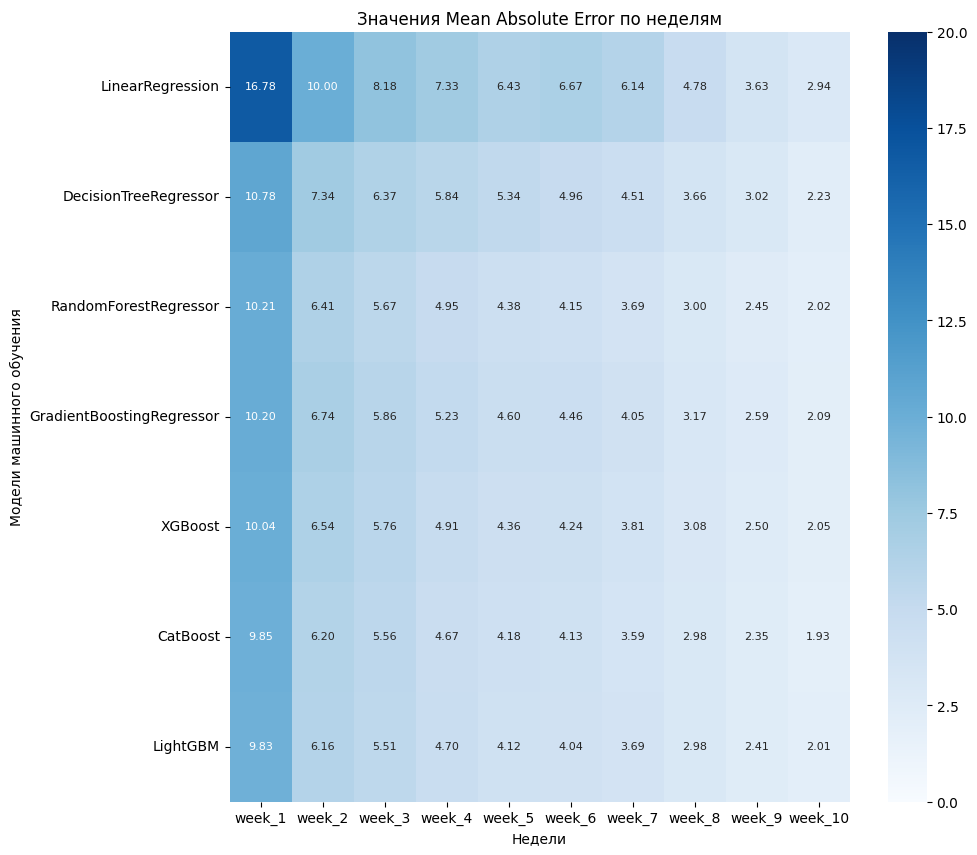

In [19]:
# Создание матрицы для тепловой карты
heatmap_data = mae_df

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f", annot_kws={"size": 8}, vmin=0, vmax=20)
plt.title('Значения Mean Absolute Error по неделям')
plt.xlabel('Недели')
plt.ylabel('Модели машинного обучения')
# plt.savefig('./outputs/maes_weekly_all.png', dpi=300, bbox_inches='tight')
plt.show()

**Вывод:** наилучший результат продемонстрировала модель случайного леса, что позволяет использовать её в качестве основной при прогнозировании показателей успеваемости обучающихся. Уже на второй неделе среднее абсолютное отклонение от реального целевого показателя составило 6,69. Это позволяет взять указанную модель за основу при дальнейшей работе.

## 4. Тестирование качества прогнозирования прогресса на разных курсах

In [20]:
# Создаем выборки по курсам для тестирования
df_77_test = val_sample[val_sample['course_id'] == 77]
df_71_test = val_sample[val_sample['course_id'] == 71]
df_49_test = val_sample[val_sample['course_id'] == 49]
df_3_test = val_sample[val_sample['course_id'] == 3]

# Новые курсы
df_82_test = val_sample[val_sample['course_id'] == 82]
df_770_test = val_sample[val_sample['course_id'] == 770]
df_76_test = val_sample[val_sample['course_id'] == 76]
df_83_test = val_sample[val_sample['course_id'] == 83]

# Определяем количество недель
num_weeks = 10

# Создаем пустые датафреймы для каждой недели для всех курсов
df_list_77 = []
df_list_71 = []
df_list_49 = []
df_list_3 = []

df_list_82 = []
df_list_770 = []
df_list_76 = []
df_list_83 = []

# Функция для создания выборок по курсам
def create_weekly_dfs(course_df, course_list):
    for week in range(num_weeks, 0, -1):
        df_week = course_df.copy()
        df_week[f'required_activities_delay_{week}_week'] = 0
        df_week[f'success_required_done_{week}_week'] = 0
        df_week[f'mean_result_required_{week}_week'] = 0
        df_week[f'cur_date_progress_{week}_week'] = 0
        df_week[f'current_progress_{week}_week'] = 0
        
        course_list.append(df_week)

# Создаем выборки для каждого курса
create_weekly_dfs(df_77_test, df_list_77)
create_weekly_dfs(df_71_test, df_list_71)
create_weekly_dfs(df_49_test, df_list_49)
create_weekly_dfs(df_3_test, df_list_3)
create_weekly_dfs(df_82_test, df_list_82)
create_weekly_dfs(df_770_test, df_list_770)
create_weekly_dfs(df_76_test, df_list_76)
create_weekly_dfs(df_83_test, df_list_83)

# Присваиваем переменные для каждой недели из списков
df_week_10_3, df_week_9_3, df_week_8_3, df_week_7_3, df_week_6_3, df_week_5_3, df_week_4_3, df_week_3_3, df_week_2_3, df_week_1_3 = df_list_3

df_week_10_49, df_week_9_49, df_week_8_49, df_week_7_49, df_week_6_49, df_week_5_49, df_week_4_49, df_week_49_49, df_week_2_49, df_week_1_49 = df_list_49

df_week_10_71, df_week_9_71, df_week_8_71, df_week_7_71, df_week_6_71, df_week_5_71, df_week_4_71, df_week_71_71, df_week_2_71, df_week_1_71 = df_list_71

df_week_10_77, df_week_9_77, df_week_8_77, df_week_7_77, df_week_6_77, df_week_5_77, df_week_4_77, df_week_3_77, df_week_2_77, df_week_1_77 = df_list_77

df_week_10_82, df_week_9_82, df_week_8_82, df_week_7_82, df_week_6_82, df_week_5_82, df_week_4_82, df_week_82_82, df_week_2_82, df_week_1_82 = df_list_82

df_week_10_770, df_week_9_770, df_week_8_770, df_week_7_770, df_week_6_770, df_week_5_770, df_week_4_770, df_week_770_770, df_week_2_770, df_week_1_770 = df_list_770

df_week_10_76, df_week_9_76, df_week_8_76, df_week_7_76, df_week_6_76, df_week_5_76, df_week_4_76, df_week_76_76, df_week_2_76, df_week_1_76 = df_list_76

df_week_10_83, df_week_9_83, df_week_8_83, df_week_7_83, df_week_6_83, df_week_5_83, df_week_4_83, df_week_82_83, df_week_2_83, df_week_1_83 = df_list_83
# Теперь у нас есть датафреймы для каждой недели по всем курсам.

#### 4.1. Тестирование на разных учебных курсах

In [21]:
# Словарь для хранения MAE
rf_maes_3 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_3 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_3
    df_week_3 = df_list_3[week - 1]  # Предполагаем, что df_list_3 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_3.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_3['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_3 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_3.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_3.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_3[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_3[week]}")

Week 1 - Mean Absolute Error: 6.7406986333558905
Week 2 - Mean Absolute Error: 3.147666458765249
Week 3 - Mean Absolute Error: 2.6227030762696084
Week 4 - Mean Absolute Error: 2.3569863984581727
Week 5 - Mean Absolute Error: 2.1637090313360474
Week 6 - Mean Absolute Error: 2.5680745734999766
Week 7 - Mean Absolute Error: 1.8443169599217988
Week 8 - Mean Absolute Error: 1.818266129032258
Week 9 - Mean Absolute Error: 1.4643333333333333
Week 10 - Mean Absolute Error: 1.0516263440860214


In [22]:
# Словарь для хранения MAE
rf_maes_49 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_49 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_49
    df_week_49 = df_list_49[week - 1]  # Предполагаем, что df_list_49 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_49.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_49['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_49 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_49.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_49.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_49[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_49[week]}")

Week 1 - Mean Absolute Error: 14.140508500046964
Week 2 - Mean Absolute Error: 8.337905325443787
Week 3 - Mean Absolute Error: 7.542544378698226
Week 4 - Mean Absolute Error: 5.87242603550296
Week 5 - Mean Absolute Error: 5.037621301775148
Week 6 - Mean Absolute Error: 16.851819188503807
Week 7 - Mean Absolute Error: 5.426927967693056
Week 8 - Mean Absolute Error: 3.09610363482671
Week 9 - Mean Absolute Error: 3.0038572545797395
Week 10 - Mean Absolute Error: 1.1255296037296039


In [23]:
# Словарь для хранения MAE
rf_maes_71 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_71 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_71
    df_week_71 = df_list_71[week - 1]  # Предполагаем, что df_list_71 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_71.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_71['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_71 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_71.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_71.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_71[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_71[week]}")

Week 1 - Mean Absolute Error: 5.9654938099348644
Week 2 - Mean Absolute Error: 2.571609666339209
Week 3 - Mean Absolute Error: 2.1233995438218742
Week 4 - Mean Absolute Error: 1.8935556498517663
Week 5 - Mean Absolute Error: 1.7025448097903022
Week 6 - Mean Absolute Error: 2.161085989830789
Week 7 - Mean Absolute Error: 1.5689962367729358
Week 8 - Mean Absolute Error: 1.4551640659386844
Week 9 - Mean Absolute Error: 1.3050973806591006
Week 10 - Mean Absolute Error: 0.9507926234653001


In [24]:
# Словарь для хранения MAE
rf_maes_77 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_77 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_77
    df_week_77 = df_list_77[week - 1]  # Предполагаем, что df_list_77 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_77.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_77['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_77 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_77.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_77.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_77[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_77[week]}")

Week 1 - Mean Absolute Error: 4.197412587412588
Week 2 - Mean Absolute Error: 2.611958041958042
Week 3 - Mean Absolute Error: 2.639755244755245
Week 4 - Mean Absolute Error: 2.265034965034965
Week 5 - Mean Absolute Error: 2.091993006993007
Week 6 - Mean Absolute Error: 3.083321678321678
Week 7 - Mean Absolute Error: 1.9458041958041958
Week 8 - Mean Absolute Error: 1.3015384615384615
Week 9 - Mean Absolute Error: 1.2242307692307692
Week 10 - Mean Absolute Error: 0.7435664335664337


In [25]:
# Словарь для хранения MAE
rf_maes_76 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_76 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_76
    df_week_76 = df_list_76[week - 1]  # Предполагаем, что df_list_76 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_76.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_76['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_76 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_76.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_76.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_76[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_76[week]}")

Week 1 - Mean Absolute Error: 19.42611111111111
Week 2 - Mean Absolute Error: 24.21833333333333
Week 3 - Mean Absolute Error: 20.762777777777778
Week 4 - Mean Absolute Error: 24.78833333333333
Week 5 - Mean Absolute Error: 29.781111111111116
Week 6 - Mean Absolute Error: 14.606666666666664
Week 7 - Mean Absolute Error: 13.711111111111112
Week 8 - Mean Absolute Error: 11.653888888888888
Week 9 - Mean Absolute Error: 10.40666666666667
Week 10 - Mean Absolute Error: 7.302777777777777


In [26]:
# Словарь для хранения MAE
rf_maes_82 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_82 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_82
    df_week_82 = df_list_82[week - 1]  # Предполагаем, что df_list_82 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_82.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_82['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_82 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_82.predict(X_week)
    
    # Вычисление MAE (если есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_82.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_82[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_82[week]}")

Week 1 - Mean Absolute Error: 36.16094594594595
Week 2 - Mean Absolute Error: 33.62486486486487
Week 3 - Mean Absolute Error: 27.13824324324324
Week 4 - Mean Absolute Error: 24.902972972972975
Week 5 - Mean Absolute Error: 20.213243243243245
Week 6 - Mean Absolute Error: 20.563783783783784
Week 7 - Mean Absolute Error: 19.441486486486486
Week 8 - Mean Absolute Error: 16.908783783783782
Week 9 - Mean Absolute Error: 19.18716216216216
Week 10 - Mean Absolute Error: 15.965945945945949


In [27]:
# Словарь для хранения MAE
rf_maes_770 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_770 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_770
    df_week_770 = df_list_770[week - 1]  # Предполагаем, что df_list_770 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_770.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_770['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_770 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_770.predict(X_week)
    
    # Вычисление MAE (если есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_770.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_770[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_770[week]}")

Week 1 - Mean Absolute Error: 25.51673469387755
Week 2 - Mean Absolute Error: 25.98877551020408
Week 3 - Mean Absolute Error: 26.721836734693877
Week 4 - Mean Absolute Error: 24.592244897959183
Week 5 - Mean Absolute Error: 21.74020408163265
Week 6 - Mean Absolute Error: 24.372040816326532
Week 7 - Mean Absolute Error: 22.829795918367346
Week 8 - Mean Absolute Error: 17.361632653061225
Week 9 - Mean Absolute Error: 21.063061224489793
Week 10 - Mean Absolute Error: 14.807755102040815


In [28]:
# Словарь для хранения MAE
rf_maes_83 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_83 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из df_83
    df_week_83 = df_list_83[week - 1]  # Предполагаем, что df_list_83 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_83.drop(['m2_progress', 'm2_success'], axis=1)
    y_week = df_week_83['m2_progress']
    
    # Загрузка обученной модели из словаря
    rf_model_83 = rf_models[f'rf_model_week_{week}']  # Получаем модель из словаря

    # Предсказания на текущих данных
    predictions = rf_model_83.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_83.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_83[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_83[week]}")

Week 1 - Mean Absolute Error: 27.17788732394366
Week 2 - Mean Absolute Error: 25.50676056338028
Week 3 - Mean Absolute Error: 22.610704225352112
Week 4 - Mean Absolute Error: 23.49788732394366
Week 5 - Mean Absolute Error: 21.153239436619717
Week 6 - Mean Absolute Error: 23.608591549295774
Week 7 - Mean Absolute Error: 19.907183098591553
Week 8 - Mean Absolute Error: 16.142112676056335
Week 9 - Mean Absolute Error: 14.489014084507042
Week 10 - Mean Absolute Error: 13.399436619718307


In [29]:
test_rf_maes = pd.DataFrame()
test_rf_maes['course_3'] = rf_maes_3
test_rf_maes['course_49'] = rf_maes_49
test_rf_maes['course_71'] = rf_maes_71
test_rf_maes['course_77'] = rf_maes_77
test_rf_maes['course_76'] = rf_maes_76
test_rf_maes['course_82'] = rf_maes_82
test_rf_maes['course_770'] = rf_maes_770
test_rf_maes['course_83'] = rf_maes_83
test_rf_maes.index = [f'week_{i}' for i in range(1, len(test_rf_maes) + 1)]

test_rf_maes = test_rf_maes.T
test_rf_maes

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10
course_3,6.740699,3.147666,2.622703,2.356986,2.163709,2.568075,1.844317,1.818266,1.464333,1.051626
course_49,14.140509,8.337905,7.542544,5.872426,5.037621,16.851819,5.426928,3.096104,3.003857,1.125530
course_71,5.965494,2.571610,2.123400,1.893556,1.702545,2.161086,1.568996,1.455164,1.305097,0.950793
course_77,4.197413,2.611958,2.639755,2.265035,2.091993,3.083322,1.945804,1.301538,1.224231,0.743566
course_76,19.426111,24.218333,20.762778,24.788333,29.781111,14.606667,13.711111,11.653889,10.406667,7.302778
course_82,36.160946,33.624865,27.138243,24.902973,20.213243,20.563784,19.441486,16.908784,19.187162,15.965946
course_770,25.516735,25.988776,26.721837,24.592245,21.740204,24.372041,22.829796,17.361633,21.063061,14.807755
course_83,27.177887,25.506761,22.610704,23.497887,21.153239,23.608592,19.907183,16.142113,14.489014,13.399437


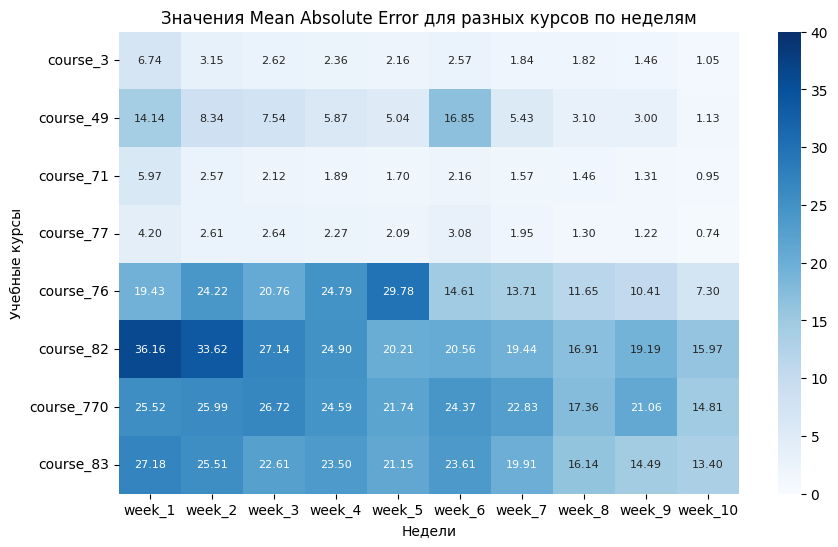

In [30]:
# Создание матрицы для тепловой карты
heatmap_data = test_rf_maes

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f", annot_kws={"size": 8}, vmin=0, vmax=40)
plt.title('Значения Mean Absolute Error для разных курсов по неделям')
plt.xlabel('Недели')
plt.ylabel('Учебные курсы')
# plt.savefig('./outputs/maes_groups.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Визуализация результатов. Сериализация моделей для их дальнейшего использования

#### 5.1. Визуализация примеров прогнозирования прогресса по курсу для разных курсов

In [31]:
# формируем датафреймы с истинными и предсказанными метками для каждой группы
true_label_3 = df_3_test[['user_id', 'm2_progress']].copy()
true_label_3.reset_index(drop=True, inplace=True)
results_3 = pd.concat([true_label_3, rf_predictions_df_3], axis=1)

In [32]:
true_label_77 = df_77_test[['user_id', 'm2_progress']].copy()
true_label_77.reset_index(drop=True, inplace=True)
results_77 = pd.concat([true_label_77, rf_predictions_df_77], axis=1)

In [33]:
true_label_71 = df_71_test[['user_id', 'm2_progress']].copy()
true_label_71.reset_index(drop=True, inplace=True)
results_71 = pd.concat([true_label_71, rf_predictions_df_71], axis=1)

In [34]:
true_label_49 = df_49_test[['user_id', 'm2_progress']].copy()
true_label_49.reset_index(drop=True, inplace=True)
results_49 = pd.concat([true_label_49, rf_predictions_df_49], axis=1)

In [35]:
true_label_76 = df_76_test[['user_id', 'm2_progress']].copy()
true_label_76.reset_index(drop=True, inplace=True)
results_76 = pd.concat([true_label_76, rf_predictions_df_76], axis=1)

In [36]:
true_label_82 = df_82_test[['user_id', 'm2_progress']].copy()
true_label_82.reset_index(drop=True, inplace=True)
results_82 = pd.concat([true_label_82, rf_predictions_df_82], axis=1)

In [37]:
true_label_83 = df_83_test[['user_id', 'm2_progress']].copy()
true_label_83.reset_index(drop=True, inplace=True)
results_83 = pd.concat([true_label_83, rf_predictions_df_83], axis=1)

In [38]:
true_label_770 = df_770_test[['user_id', 'm2_progress']].copy()
true_label_770.reset_index(drop=True, inplace=True)
results_770 = pd.concat([true_label_770, rf_predictions_df_770], axis=1)

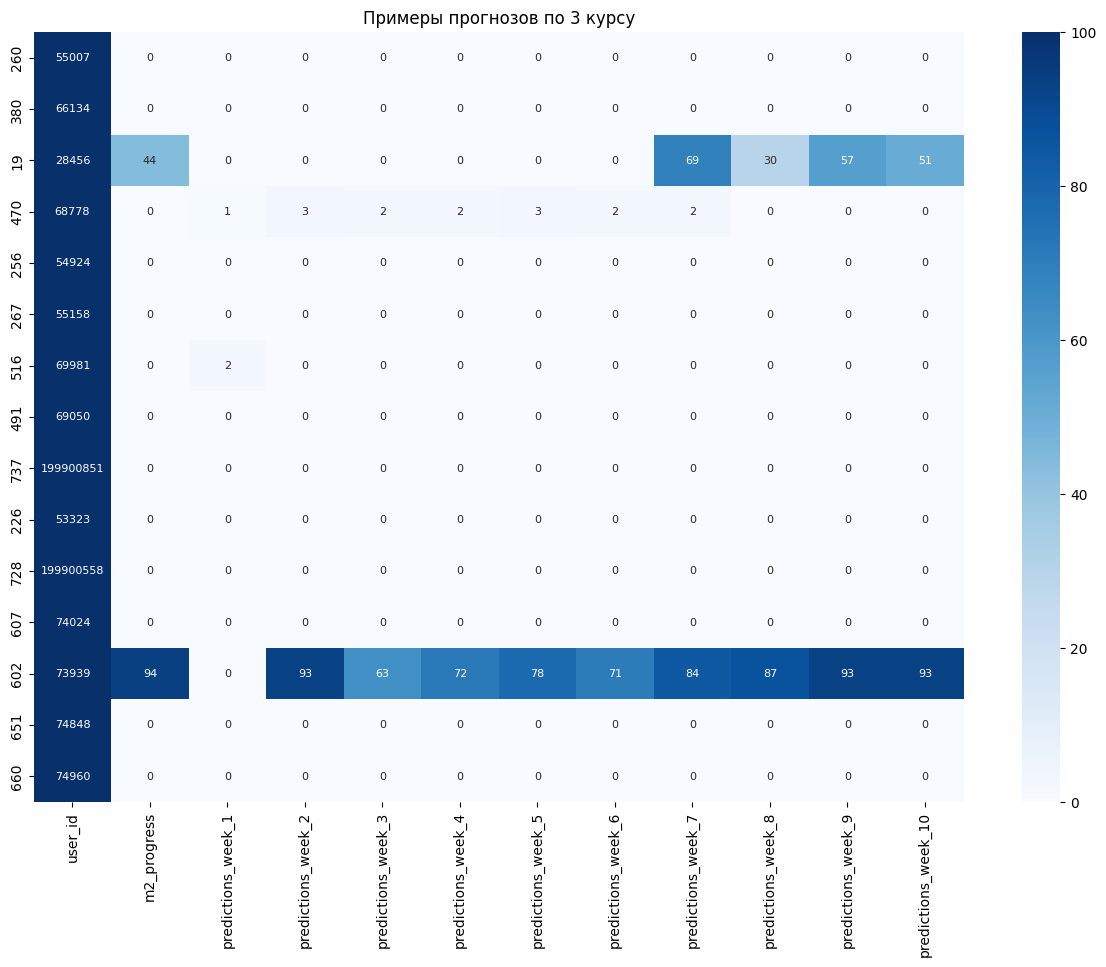

In [39]:
# визуализируем результаты прогнозирования на тепловой карте
samples_3 = results_3.sample(15)
samples_3 = samples_3.astype(int)

heatmap_data = samples_3

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 3 курсу')

# сохраняем график в файл при необходимости
# plt.savefig('./outputs/samples_3.png', dpi=300, bbox_inches='tight')
plt.show()

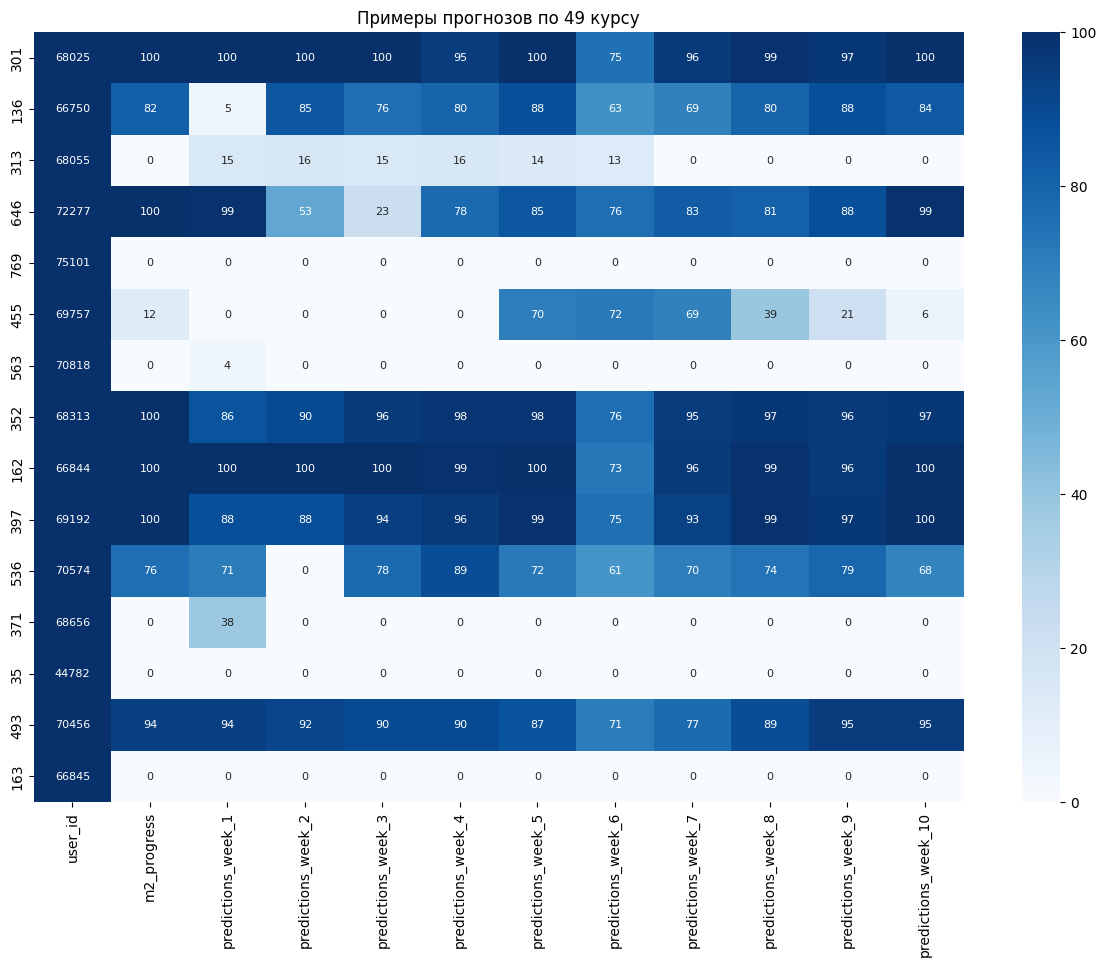

In [40]:
samples_49 = results_49.sample(15)
samples_49 = samples_49.astype(int)

heatmap_data = samples_49

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 49 курсу')
# plt.savefig('./outputs/samples_49.png', dpi=300, bbox_inches='tight')
plt.show()

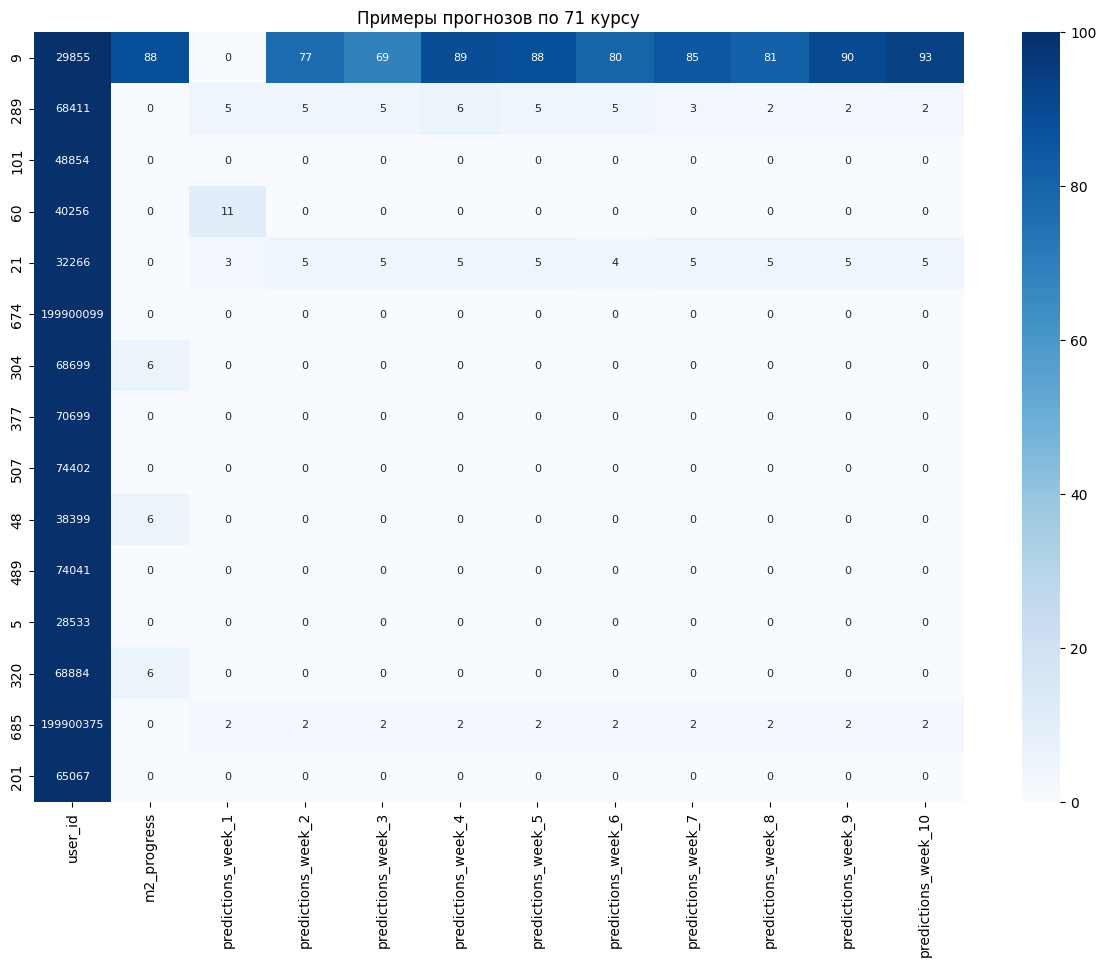

In [41]:
samples_71 = results_71.sample(15)
samples_71 = samples_71.astype(int)

heatmap_data = samples_71

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 71 курсу')
# plt.savefig('./outputs/samples_71.png', dpi=300, bbox_inches='tight')
plt.show()

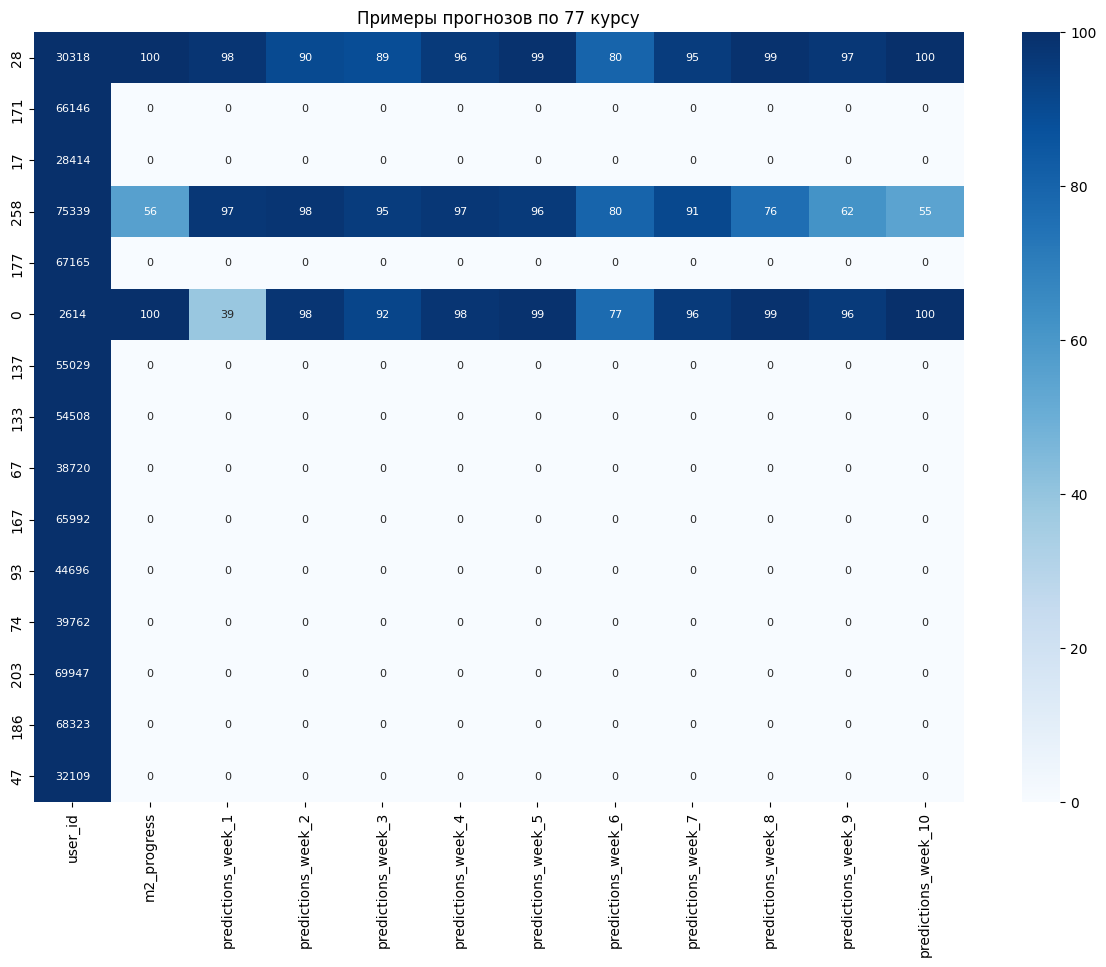

In [42]:
samples_77 = results_77.sample(15)
samples_77 = samples_77.astype(int)

heatmap_data = samples_77

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 77 курсу')
# plt.savefig('./outputs/samples_77.png', dpi=300, bbox_inches='tight')
plt.show()

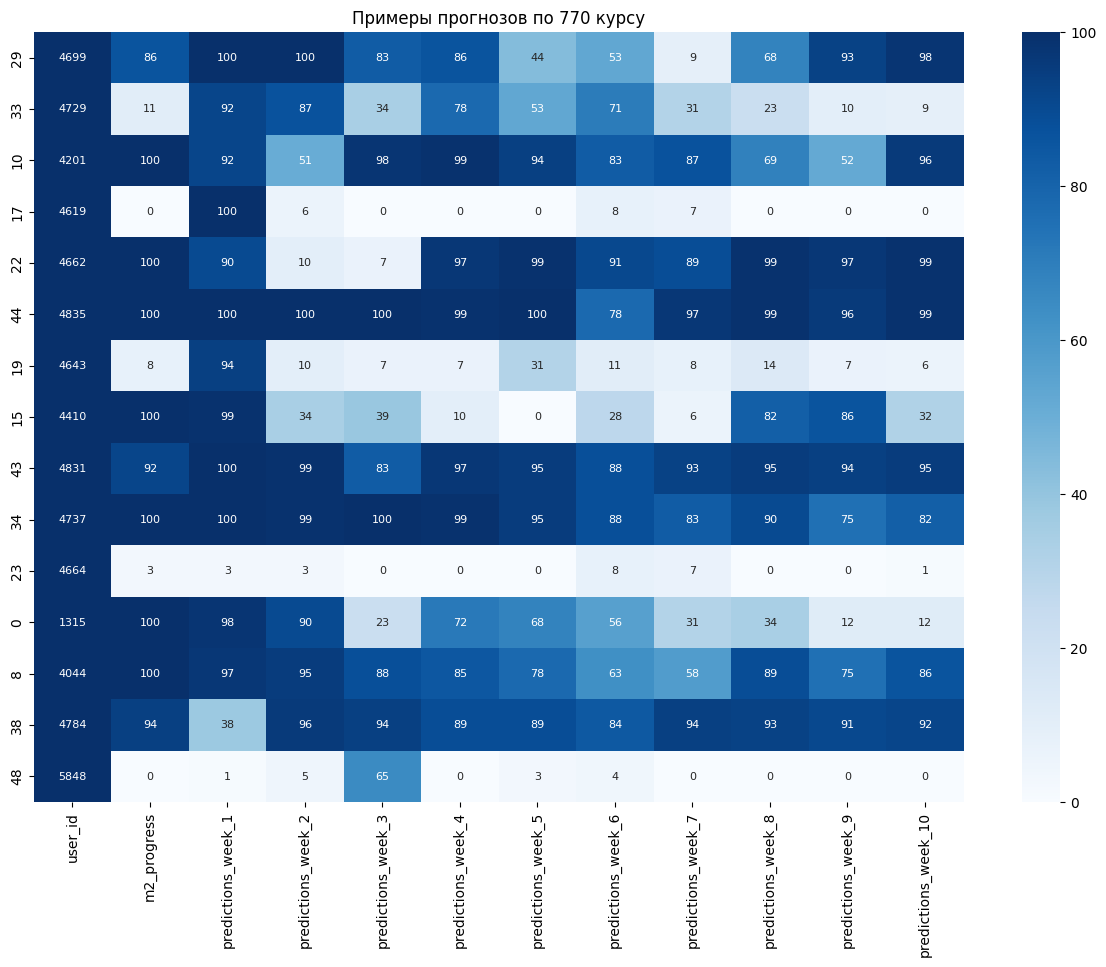

In [43]:
samples_770 = results_770.sample(15)
samples_770 = samples_770.astype(int)

heatmap_data = samples_770

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 770 курсу')
# plt.savefig('./outputs/samples_770.png', dpi=300, bbox_inches='tight')
plt.show()

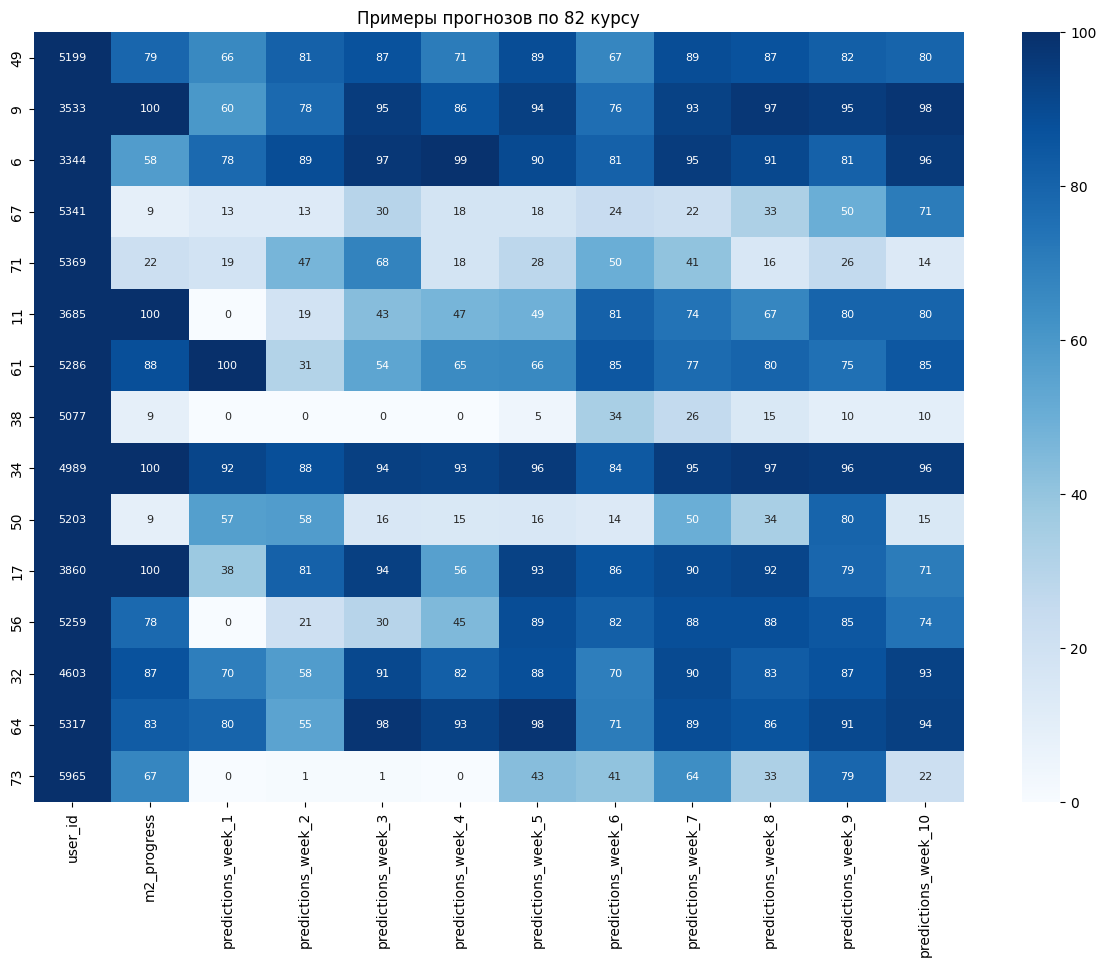

In [44]:
samples_82 = results_82.sample(15)
samples_82 = samples_82.astype(int)

heatmap_data = samples_82

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 82 курсу')
# plt.savefig('./outputs/samples_82.png', dpi=300, bbox_inches='tight')
plt.show()

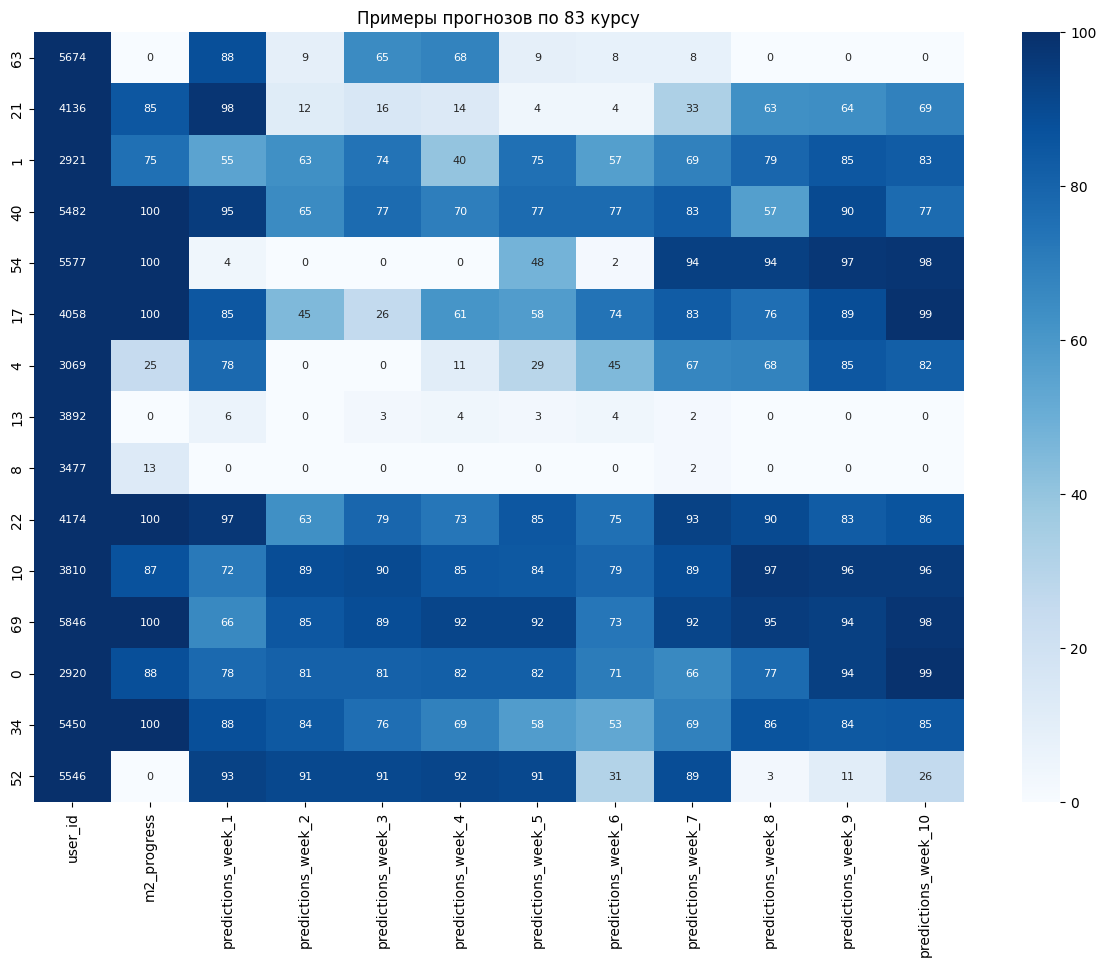

In [45]:
samples_83 = results_83.sample(15)
samples_83 = samples_83.astype(int)

heatmap_data = samples_83

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 83 курсу')
# plt.savefig('./outputs/samples_83.png', dpi=300, bbox_inches='tight')
plt.show()

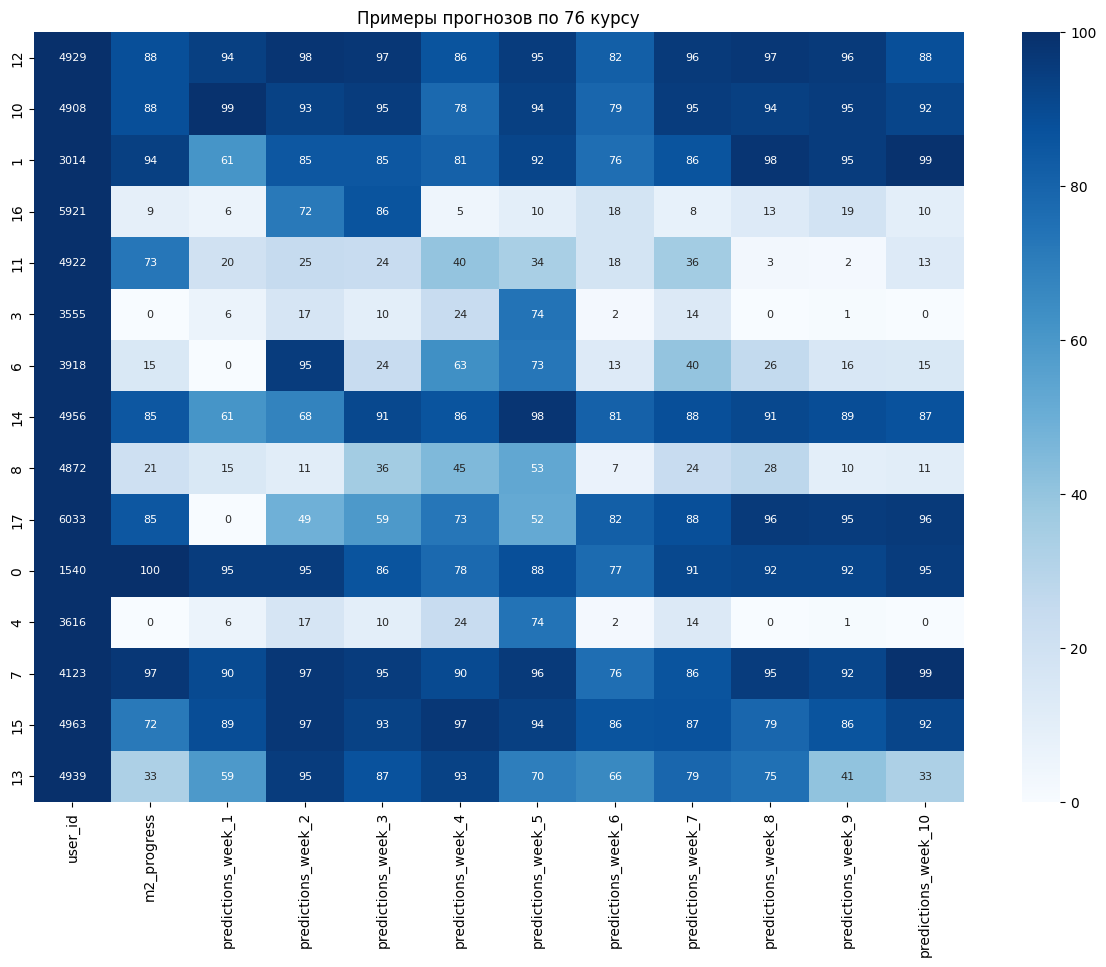

In [46]:
samples_76 = results_76.sample(15)
samples_76 = samples_76.astype(int)

heatmap_data = samples_76

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt="d", annot_kws={"size": 8}, vmin=0, vmax=100)
plt.title('Примеры прогнозов по 76 курсу')
# plt.savefig('./outputs/samples_76.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# словарь моделей случайного леса по каждой неделе
rf_models

{'rf_model_week_1': RandomForestRegressor(),
 'rf_model_week_2': RandomForestRegressor(),
 'rf_model_week_3': RandomForestRegressor(),
 'rf_model_week_4': RandomForestRegressor(),
 'rf_model_week_5': RandomForestRegressor(),
 'rf_model_week_6': RandomForestRegressor(),
 'rf_model_week_7': RandomForestRegressor(),
 'rf_model_week_8': RandomForestRegressor(),
 'rf_model_week_9': RandomForestRegressor(),
 'rf_model_week_10': RandomForestRegressor()}

#### 5.2. Сериализация моделей

In [48]:
# import joblib  # Импортируем библиотеку для сериализации
# import os

# # Укажите директорию для сохранения моделей
# model_dir = './saved_models'

# # Создаем директорию, если она не существует
# os.makedirs(model_dir, exist_ok=True)

# {'rf_model_week_1': RandomForestRegressor(max_features='log2', n_estimators=50),
#  'rf_model_week_2': RandomForestRegressor(max_features='log2', n_estimators=50),
#  'rf_model_week_3': RandomForestRegressor(max_features='log2', n_estimators=50),
#  'rf_model_week_4': RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=200),
#  'rf_model_week_5': RandomForestRegressor(max_features='log2', n_estimators=50),
#  'rf_model_week_6': RandomForestRegressor(max_features='log2', n_estimators=200),
#  'rf_model_week_7': RandomForestRegressor(max_features='sqrt', n_estimators=200),
#  'rf_model_week_8': RandomForestRegressor(max_features='sqrt', n_estimators=200),
#  'rf_model_week_9': RandomForestRegressor(max_features='sqrt', n_estimators=200),
#  'rf_model_week_10': RandomForestRegressor(max_features='sqrt', n_estimators=200)}

# # Сериализация моделей на диск
# for model_name, model in rf_models.items():
#     model_filename = os.path.join(model_dir, f'{model_name}.joblib')  # Создаем имя файла для модели
#     joblib.dump(model, model_filename)  # Сохраняем модель в файл
#     print(f"Модель '{model_name}' успешно сохранена в '{model_filename}'")

# print(f"\nВсе модели успешно сохранены в директорию: {model_dir}")

## 6. Обучение моделей, прогнозирующих вероятность успешного завершения курса

*Эксперимент по выбору наиболее результативной модели прогнозирования вероятности успешного завершения курса проводился отдельно. Наилучшие результаты показала модель градиентного бустинга, в связи с этим считаем возможным не проводить этот эксперимент повторно, а сразу обучить оптимальную модель.*

#### 6.1. Обучение моделей градиентного бустинга, прогнозирующих вероятность успешного окончания курсов

In [49]:
"""
Загрузка сохранённых датасетов нужна для чистоты эксперимента - 
чтобы обучающая и валидационная выборки для моделей прогнозирования прогресса по курсу
и моделей, прогнозирующих вероятность завершения курса, совпадали.
Если обучение моделей проводится в одну сессию выполнения кода, 
необходимости в загрузке сохранённых датасетов нет.

"""
# Загрузка сохраненных датасетов
import os
import pandas as pd

# Папка, из которой будем загружать файлы
load_directory = './saved_datasets/'

# Словарь для хранения загруженных датафреймов
train_datasets = {}
val_datasets = {}

def load_datasets(directory):
    """Загружает обучающие и валидационные наборы данных из указанной директории."""
    global train_datasets, val_datasets
    
    # Чтение обучающих данных
    for i in range(1, 11):  # от 1 до 10 включительно
        file_name_train = f'{directory}train_week_{i}.csv'
        if os.path.exists(file_name_train):
            train_datasets[f'train_week_{i}'] = pd.read_csv(file_name_train)
            print(f'Успешно загружен: {file_name_train}')
        else:
            print(f'Файл не найден: {file_name_train}')

    # Чтение валидационных данных
    for i in range(1, 11):  # от 1 до 10 включительно
        file_name_val = f'{directory}val_week_{i}.csv'
        if os.path.exists(file_name_val):
            val_datasets[f'val_week_{i}'] = pd.read_csv(file_name_val)
            print(f'Успешно загружен: {file_name_val}')
        else:
            print(f'Файл не найден: {file_name_val}')

# Загружаем датасеты
load_datasets(load_directory)

# Создаем переменные для доступа к загруженным датафреймам
for i in range(1, 11):
    globals()[f'train_week_{i}'] = train_datasets.get(f'train_week_{i}', None)
    globals()[f'val_week_{i}'] = val_datasets.get(f'val_week_{i}', None)

Успешно загружен: ./saved_datasets/train_week_1.csv
Успешно загружен: ./saved_datasets/train_week_2.csv
Успешно загружен: ./saved_datasets/train_week_3.csv
Успешно загружен: ./saved_datasets/train_week_4.csv
Успешно загружен: ./saved_datasets/train_week_5.csv
Успешно загружен: ./saved_datasets/train_week_6.csv
Успешно загружен: ./saved_datasets/train_week_7.csv
Успешно загружен: ./saved_datasets/train_week_8.csv
Успешно загружен: ./saved_datasets/train_week_9.csv
Успешно загружен: ./saved_datasets/train_week_10.csv
Успешно загружен: ./saved_datasets/val_week_1.csv
Успешно загружен: ./saved_datasets/val_week_2.csv
Успешно загружен: ./saved_datasets/val_week_3.csv
Успешно загружен: ./saved_datasets/val_week_4.csv
Успешно загружен: ./saved_datasets/val_week_5.csv
Успешно загружен: ./saved_datasets/val_week_6.csv
Успешно загружен: ./saved_datasets/val_week_7.csv
Успешно загружен: ./saved_datasets/val_week_8.csv
Успешно загружен: ./saved_datasets/val_week_9.csv
Успешно загружен: ./saved_dat

In [50]:
# Выводим пример датасета за неделю, проверяем его. 
# Значения {признак}_{n+1}_week для n-й недели должны быть нулевыми
train_week_2

,user_id,course_id,required_activities_delay_1_week,required_activities_delay_2_week,required_activities_delay_3_week,required_activities_delay_4_week,required_activities_delay_5_week,required_activities_delay_6_week,required_activities_delay_7_week,required_activities_delay_8_week,...,current_progress_3_week,current_progress_4_week,current_progress_5_week,current_progress_6_week,current_progress_7_week,current_progress_8_week,current_progress_9_week,current_progress_10_week,m2_progress,m2_success
0,75617,77,10,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,0
1,28545,77,10,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,77287,77,9,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100,1
3,75500,77,10,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28349,77,10,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2872,83,6,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,83,1
11996,5674,83,6,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,3488,83,6,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,6229,83,6,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,0


In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Функция обучения модели градиентного бустинга
def create_gradient_boosting(X, y):
    # Создание и настройка модели градиентного бустинга
    gb_model = GradientBoostingClassifier()

    # Обучение модели
    gb_model.fit(X, y)

    return gb_model  # Возвращаем модель

# Словарь для хранения моделей и списки для метрик
gb_models = {}  # Словарь для моделей
gb_metrics = []  # Список для метрик

# Создание списка для хранения предсказаний и вероятностей
gb_predictions = []
gb_probabilities = []

# Цикл от 1 до 10 для обучения моделей на обучающих данных
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из обучающей выборки
    train_week = globals()[f'train_week_{week}']
    
    # Подготовка данных для обучения
    X_week = train_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_week = train_week['m2_success']  # Целевая переменная
    
    # Обучение модели градиентного бустинга
    gb_model = create_gradient_boosting(X_week, y_week)

    # Сохранение модели в словарь
    gb_models[f'gb_model_week_{week}'] = gb_model  # Добавляем модель в словарь

    # Предсказания на валидационных данных
    val_week = globals()[f'val_week_{week}']
    X_val_week = val_week.drop(['m2_progress', 'm2_success'], axis=1)  # Оставляем все столбцы, кроме целевой переменной
    y_val_week = val_week['m2_success']  # Целевая переменная

    predictions = gb_model.predict(X_val_week)
    predictions_proba = gb_model.predict_proba(X_val_week)[:, 1]  # Вероятности положительного класса

    # Оценка модели на валидационных данных по различным метрикам
    accuracy = accuracy_score(y_val_week, predictions)
    precision = precision_score(y_val_week, predictions)
    f1 = f1_score(y_val_week, predictions)
    roc_auc = roc_auc_score(y_val_week, predictions_proba)

    # Сохранение метрик в список
    gb_metrics.append({
        'week': week,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

    # Добавление предсказаний и вероятностей в списки
    gb_predictions.append(predictions)
    gb_probabilities.append(predictions_proba)

# Преобразование списка метрик в DataFrame
metrics_df_gb = pd.DataFrame(gb_metrics)

# Вывод метрик для каждой недели на валидационных данных
display(metrics_df_gb)

,week,accuracy,precision,f1,roc_auc
0,1,0.909,0.857,0.822,0.930
1,2,0.927,0.863,0.864,0.969
2,3,0.931,0.868,0.872,0.977
3,4,0.939,0.874,0.887,0.981
4,5,0.939,0.877,0.888,0.984
5,6,0.949,0.887,0.907,0.984
6,7,0.951,0.886,0.911,0.985
7,8,0.955,0.890,0.918,0.987
8,9,0.959,0.908,0.925,0.987
9,10,0.961,0.906,0.928,0.988


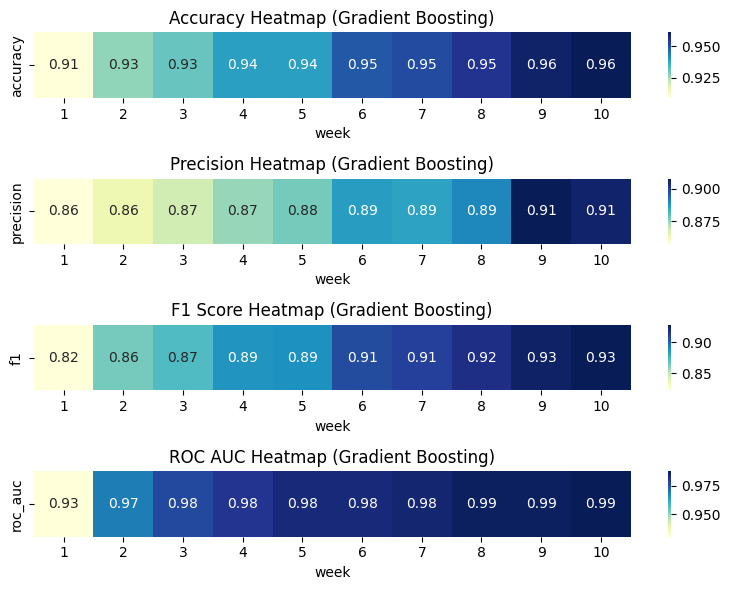

In [52]:
# Визуализация метрик с помощью тепловых карт
plt.figure(figsize=(8, 6))

# Accuracy Heatmap
plt.subplot(4, 1, 1)
sns.heatmap(metrics_df_gb[['week', 'accuracy']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Accuracy Heatmap (Gradient Boosting)')

# Precision Heatmap
plt.subplot(4, 1, 2)
sns.heatmap(metrics_df_gb[['week', 'precision']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Precision Heatmap (Gradient Boosting)')

# F1 Score Heatmap
plt.subplot(4, 1, 3)
sns.heatmap(metrics_df_gb[['week', 'f1']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('F1 Score Heatmap (Gradient Boosting)')

# ROC AUC Heatmap
plt.subplot(4, 1, 4)
sns.heatmap(metrics_df_gb[['week', 'roc_auc']].set_index('week').T, annot=True, cmap='YlGnBu', cbar=True)
plt.title('ROC AUC Heatmap (Gradient Boosting)')

plt.tight_layout()
# Сохраняем тепловую карту с метриками
# plt.savefig('./outputs/gb_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

#### 6.2. Сериализация моделей, прогнозирующих вероятность успешного завершения курсов

In [53]:
# Словарь моделей классификаторов градиентного бустинга по каждой неделе
gb_models

{'gb_model_week_1': GradientBoostingClassifier(),
 'gb_model_week_2': GradientBoostingClassifier(),
 'gb_model_week_3': GradientBoostingClassifier(),
 'gb_model_week_4': GradientBoostingClassifier(),
 'gb_model_week_5': GradientBoostingClassifier(),
 'gb_model_week_6': GradientBoostingClassifier(),
 'gb_model_week_7': GradientBoostingClassifier(),
 'gb_model_week_8': GradientBoostingClassifier(),
 'gb_model_week_9': GradientBoostingClassifier(),
 'gb_model_week_10': GradientBoostingClassifier()}

In [54]:
# import joblib  # Импортируем библиотеку для сериализации
# import os

# # Укажите директорию для сохранения моделей
# model_dir = './saved_clf_models'

# # Создаем директорию, если она не существует
# os.makedirs(model_dir, exist_ok=True)

# {'gb_model_week_1': GradientBoostingClassifier(),
#  'gb_model_week_2': GradientBoostingClassifier(),
#  'gb_model_week_3': GradientBoostingClassifier(),
#  'gb_model_week_4': GradientBoostingClassifier(),
#  'gb_model_week_5': GradientBoostingClassifier(),
#  'gb_model_week_6': GradientBoostingClassifier(),
#  'gb_model_week_7': GradientBoostingClassifier(),
#  'gb_model_week_8': GradientBoostingClassifier(),
#  'gb_model_week_9': GradientBoostingClassifier(),
#  'gb_model_week_10': GradientBoostingClassifier()}

# # Сериализация моделей на диск
# for model_name, model in gb_models.items():
#     model_filename = os.path.join(model_dir, f'{model_name}.joblib')  # Создаем имя файла для модели
#     joblib.dump(model, model_filename)  # Сохраняем модель в файл
#     print(f"Модель '{model_name}' успешно сохранена в '{model_filename}'")

# print(f"\nВсе модели успешно сохранены в директорию: {model_dir}")